main.py / Risk-Managed Portfolio Strategy (Trend + Volatility)
--------------------------------------------------------------
What this script does:
1) Downloads historical prices
2) Builds daily returns and wealth
3) Implements strategies:
   Buy & Hold
   Trend Strenght Scaling
   Volatility Targeting
   Trend + Volatility
4) Computes risk/performance metrics:
   CAGR, annualized volatility, Sharpe ratio, maximum drowdown
5) Plots equity curves

In [67]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#--------------------------------------------------
#Global parameters
#--------------------------------------------------
ticker = 'SPY' 
start = '2005-01-01'
end = None
trading_days = 250
seed = 42
price = yf.download(ticker, start, end, auto_adjust = False)['Adj Close']
#Strategy parameters
sma_window = 200
vol_window = 30
clip_min = 0.0
clip_max = 1.5

#Plot parameters 
figsize = (20,10)


[*********************100%***********************]  1 of 1 completed


In [64]:
#--------------------------------------------------
#1)Data helpers
#--------------------------------------------------

#Daily simple return
def simple_returns(price):
    r = price.pct_change().dropna()
    r.name = 'returns'
    return r

def wealth_from_returns(returns):
    w = (1 + returns).cumprod()
    w.name = 'wealth'
    return w


In [70]:
#--------------------------------------------------
#2)Performance and risk metrics
#--------------------------------------------------

#Compound annual growth rate based on wealth series

def cagr(wealth):
    n_days = len(wealth)
    years = n_days /trading_days
    return (wealth.iloc[-1]/wealth.iloc[0])**(1/years) - 1

#Annualized volatility 

def annualized_volatility(returns):
    return returns.std() * np.sqrt(trading_days)

#Sharpe ratio (assuming constant risk-free-rate)

def sharpe(returns):
    return (returns.mean()*trading_days)/(returns.std()*np.sqrt(trading_days))

#Maximum drowdown on a wealth series

def max_drowdown(wealth):
    peak = wealth.cummax()
    drowdown = wealth/peak - 1
    return drowdown.min()

#Summary table

def performance_stats(returns, wealth):
     return pd.Series({
            'CAGR' : float(cagr(wealth)),
            'Ann. Vol.' : float(annualized_volatility(returns)),
            'Sharpe' : float(sharpe(returns)),
            'Max Drowdown' : float(max_drowdown(wealth))})
  

In [73]:
#--------------------------------------------------
#3)Strategy builders 
#--------------------------------------------------

#Buy & Hold

def buy_and_hold(price):
    returns = simple_returns(price)
    wealth = wealth_from_returns(returns)
    return returns, wealth

#Trend-stregth scaling: if price is above sma -> ratio > 1, higher exposure, else lower exposure

def sma_stregth_weights(price, sma_window, clip_min = 0, clip_max = 1):
    sma = price.rolling(sma_window).mean()
    returns =  simple_returns(price)
    indicator = (price/sma).clip(clip_min,clip_max)
    weights = indicator.shift(1).dropna()
    weights = weights.reindex(returns.index).fillna(0)
    strat_returns = weights * returns
    wealth = wealth_from_returns(strat_returns)
    return strat_returns, wealth

#Volatility targeting

def volatility_target_weights(price, vol_window, clip_min = 0, clip_max = 1):
    returns =  simple_returns(price)
    vol = returns.rolling(vol_window).std()
    vol_ref = vol.median()
    indicator = (vol_ref/vol).clip(clip_min, clip_max)
    weights = indicator.shift(1).dropna()
    weights = weights.reindex(returns.index).fillna(0)
    strat_returns = weights * returns
    wealth = wealth_from_returns(strat_returns)
    return strat_returns, wealth

#Trend + Volatility

def trend_vol_strategy(price, sma_window = 200, vol_window = 30, clip_min = 0, clip_max = 1):
    returns =  simple_returns(price)
    vol = returns.rolling(vol_window).std()
    vol_ref = vol.median()
    indicator_vol = (vol_ref/vol).clip(clip_min, clip_max)
    sma = price.rolling(sma_window).mean()
    indicator_sma = (price/sma).clip(clip_min,clip_max)

    weights = (indicator_vol*indicator_sma).shift(1).dropna()
    weights = weights.reindex(returns.index).fillna(0)
    strat_returns = weights * returns
    wealth = wealth_from_returns(strat_returns)
    return strat_returns, wealth


In [78]:
#--------------------------------------------------
#4)Run strategies and evaluatin
#--------------------------------------------------

bh_ret, bh_wealth = buy_and_hold(price)
sma_ret, sma_wealth = sma_stregth_weights(price, sma_window, clip_min = 0, clip_max = 1)
vol_ret, vol_wealth = volatility_target_weights(price, vol_window, clip_min = 0, clip_max = 1)
tv_ret, tv_wealth = trend_vol_strategy(price, sma_window = 200, vol_window = 30, clip_min = 0, clip_max = 1)

#Build comparison table

pd.DataFrame({
    'Buy and Hold' : performance_stats(bh_ret, bh_wealth),
    'SMA strenght': performance_stats(sma_ret, sma_wealth),
    'Volatility target' : performance_stats(vol_ret, vol_wealth),
    'Trend + Volatility' : performance_stats(tv_ret, tv_wealth)})



C:\Users\UTENTE\AppData\Local\Temp\ipykernel_1944\2202943765.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'CAGR' : float(cagr(wealth)),
C:\Users\UTENTE\AppData\Local\Temp\ipykernel_1944\2202943765.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Ann. Vol.' : float(annualized_volatility(returns)),
C:\Users\UTENTE\AppData\Local\Temp\ipykernel_1944\2202943765.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Sharpe' : float(sharpe(returns)),
C:\Users\UTENTE\AppData\Local\Temp\ipykernel_1944\2202943765.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Max Drowdown' : float(max_dro

,Buy and Hold,SMA strenght,Volatility target,Trend + Volatility
CAGR,0.106858,0.102012,0.092506,0.090794
Ann. Vol.,0.189613,0.171693,0.119797,0.115712
Sharpe,0.627341,0.651961,0.798696,0.809182
Max Drowdown,-0.551895,-0.510368,-0.299750,-0.284247


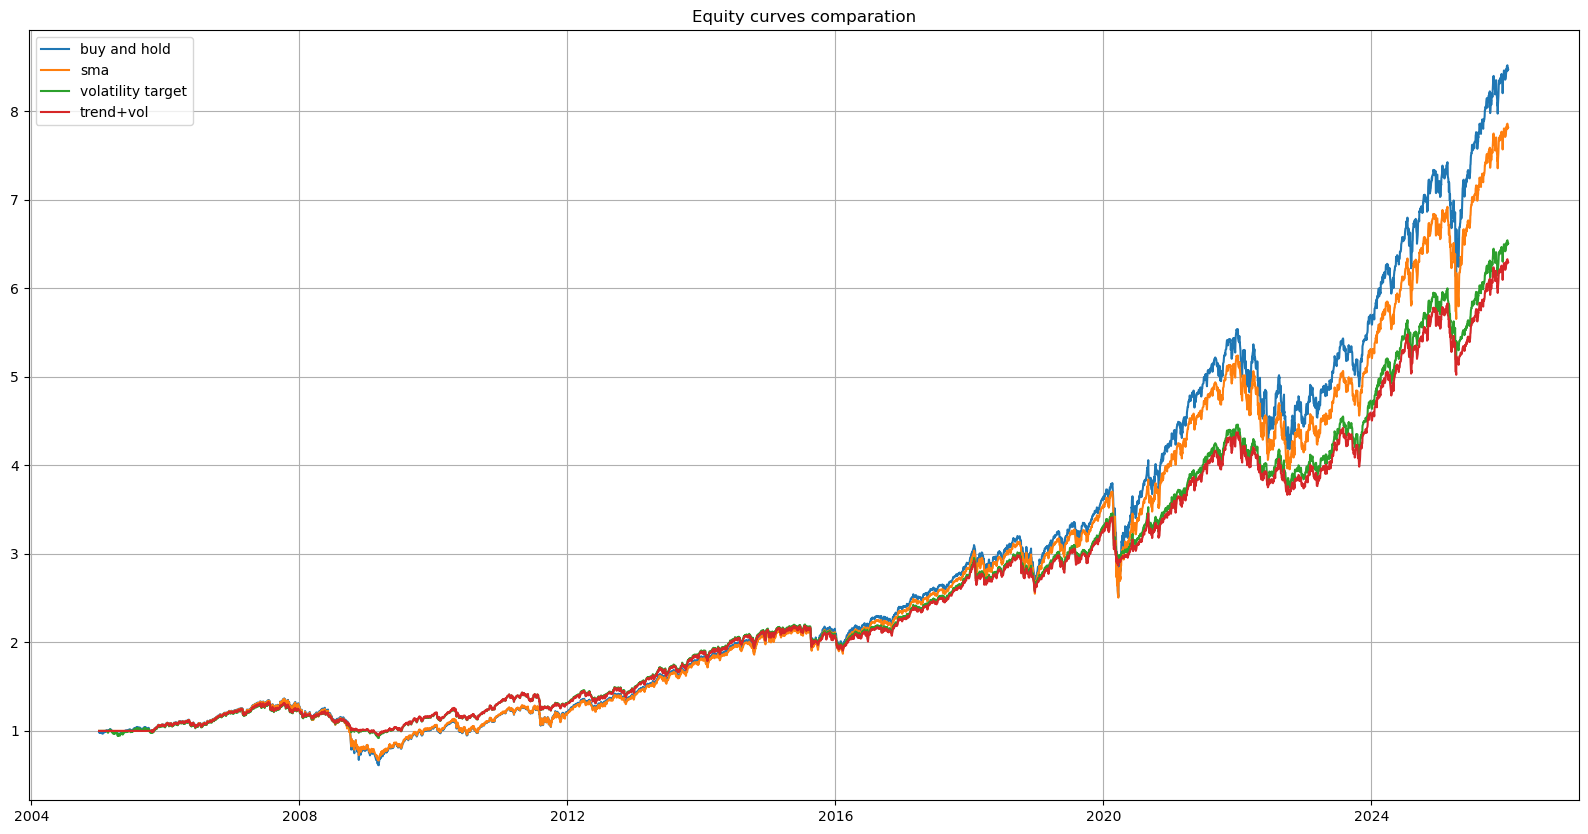

In [77]:
#Plot equity curves (aligned)

plt.figure(figsize = figsize)
plt.plot(bh_wealth, label = 'buy and hold')
plt.plot(sma_wealth, label = 'sma')
plt.plot(vol_wealth, label = 'volatility target')
plt.plot(tv_wealth, label = 'trend+vol')
plt.title('Equity curves comparation')
plt.grid(True)
plt.legend()
plt.show()